<a href="https://colab.research.google.com/github/blackgreenc/Paper/blob/main/Tacotron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><strong>Tacotron논문</strong></h1>
<h2 style="color:red">이 논문의 큰 특징</h2>
<br>
<h3>
1, Attention기반 Seq-toSeq TTS 모델 구조를 제시함
<br>
2, <문장, 음성>쌍으로 이루어진 데이터만으로 <u>별도의 작업없이</u> 학습이 가능한 End-to-End 모델이다.
<br>
3, 음성합성 품질이 뛰어나다.
</h3>



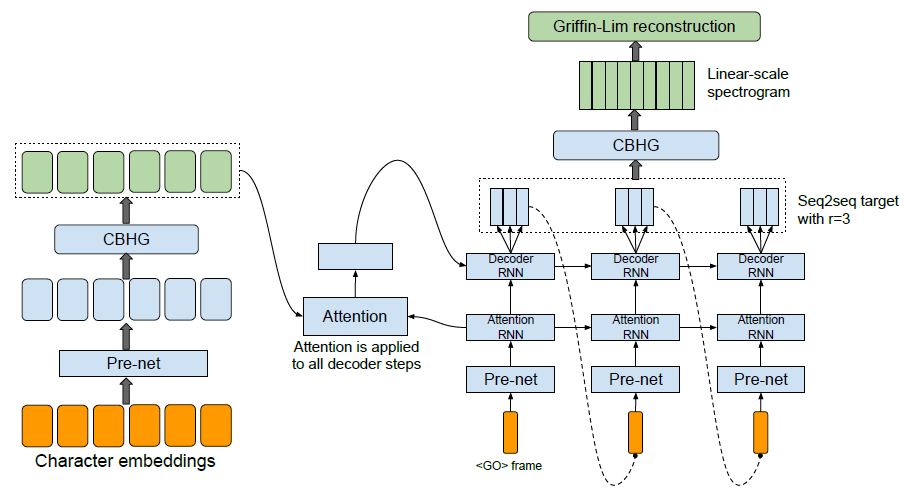

><h5>Tacotron모델 전체구조</h5>

<h3>모델은 크게 문장을 input으로 받아 정보를 추출하는 Encoder,  Encoder로부터 추출된 정보를 이용하여 멜 스펙토그램을 생성하는 Decoder, Encoder의 정보를 Decoder에 mapping해주는 Attention, 마지막으로 Decoder에서 생성된 델 스펙토그램을 이용하여 Linear스펙토그램을 생성하는 후처리부분으로 나뉠 수 있다. 그리고 추가적으로 모델로부터 나온 최종 결과물인 Linear스펙토그램을 오디오로 바꿔주는 Grifin-Lim알고리즘이 있다. Encoder와 Decoder 안에는 공통적으로 반복되는 CBHG공통 모듈이 존재한다.</h3>

<h1>1, Input and Output</h1>

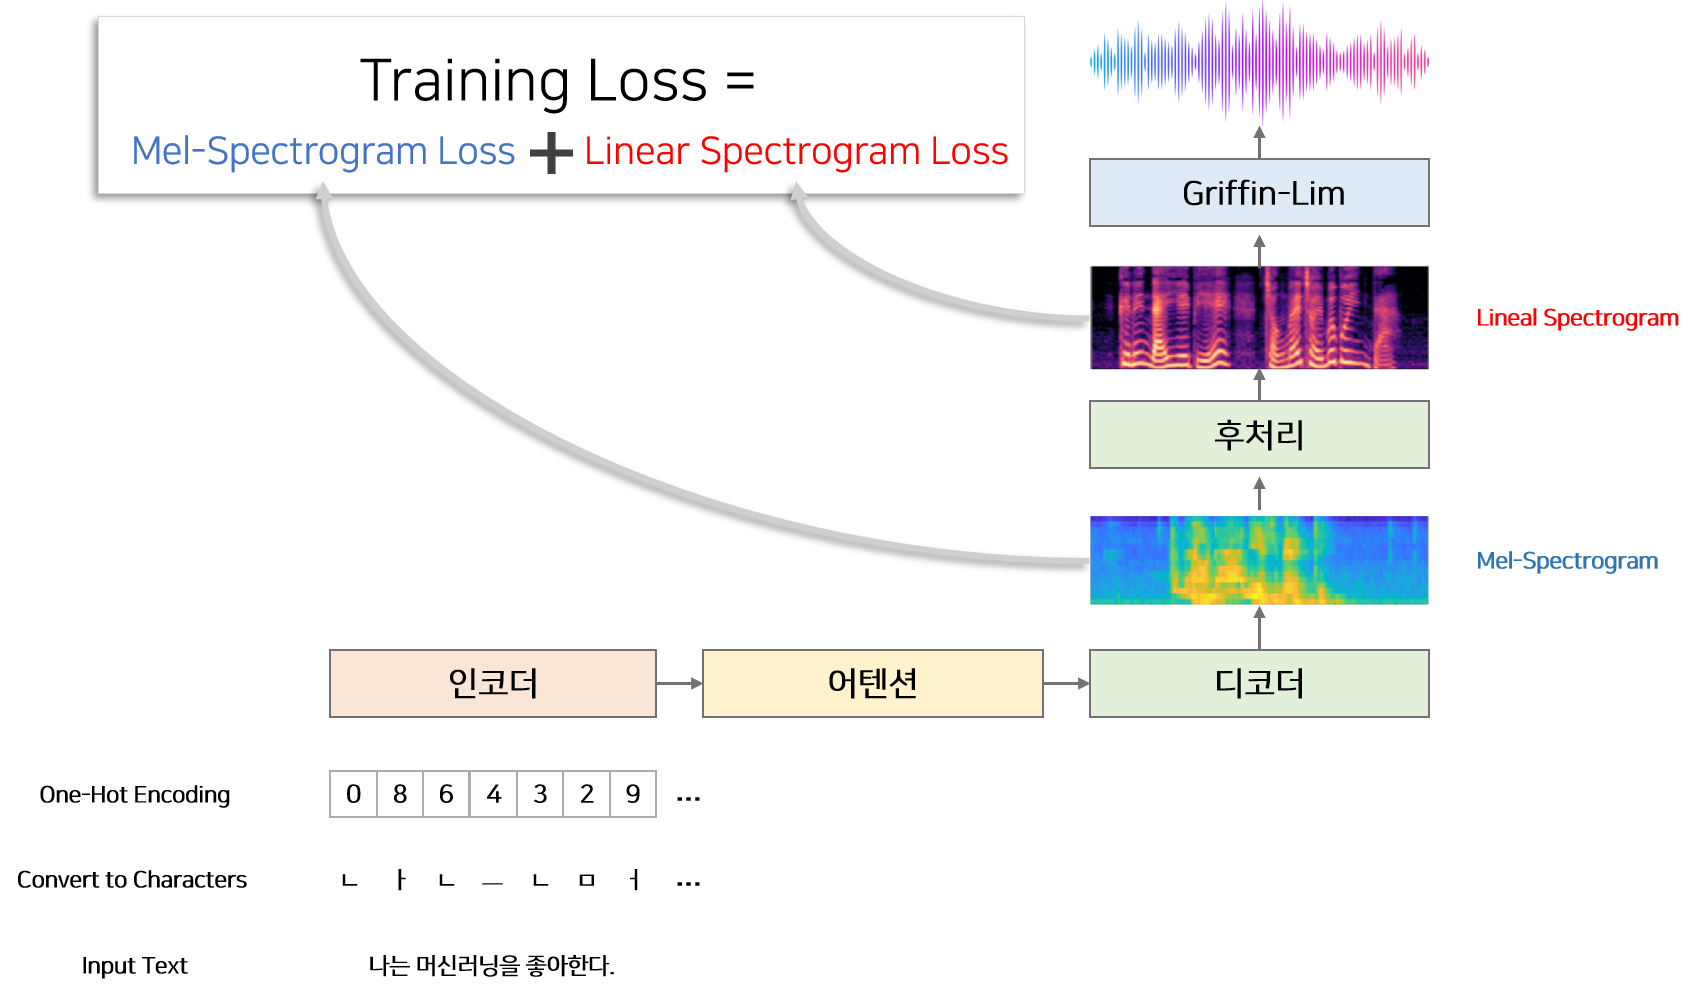

<h3>모델의 Training 및 Inference단계에서 input은 character단위의 One-hot vector이다. 따라서 영어 문장을 모델에 넣기 위해서는 문장을 character단위로 나누고 One-hot Encoding하는 작업이 필요합니다. 예를들어 'I love you'문장은 각각 한개의 character 'i', '', 'l', 'o', 'v', 'e', 'y', 'o', 'u'로 나누고 One-hot Encoding을 통해 각 character에 맞는 숫자열[8, 6, 13, ...., 2]로 변형한 뒤 모델의 input으로 사용한다. 한글의 경우 문장을 초성, 중성, 종성, 그리고 문장 부호로 나누어 총 80개의 character로 문자를 나누고 난 뒤 One-hot Encoding을 통해 숫자열로 변형한다.</h3>

<h4><i>한글의 경우 초성과 종성의 자음은 각각 다른 Character로 Embading하여 처리한다. 예를 들어 나는 ==>[ㄴ,ㅏ, ㄴ, ㅡ, ㄴ] -> [2, 4, 2, 5, 8]으로 표현된 것처럼 'ㄴ'은 초성, 종성에 따라 다르게 Embading된다.</i></h4>

<h3>모델의 Inference단계에서 Output은 Linear 스펙트로그램입니다. 모델을 학습할 때에는 후처리 부분에서의 Output인 Linear스펙토그램 뿐만 아니라 Decoder부분에서의 Output인 멜 스펙토그램을 함께 사용한다. 즉 손실합수를 Linear 스펙토그램 Loss + 멜 스펙토그램 Loss로 구성하여 학습한다.</h3>

스펙토그램 : 스펙토그램(Spectogram)은 소리나 파동을 시각화하여 파악하기 위한 도구로, 파형(waveform)과 스펙트럼(Spectrum)의 특징이 조합되어 있다. 파형에서는 시간축의 변화에 따른 진폭 축의 변화를 볼 수 있는 반면, 스펙토그램에서는 시간축과 주파수 축의 변화에 따라 진폭의 차이를 인쇄 농도 / 표시 색상의 차이로 나타낸다.

<h4><i>모델에 사용하는 Linear스펙트로그램은 Short-Time Fourier Transform뿐만 아니라 로그스케일, 노말라이징, 데시벨 스케일링 등의 다양한 전처리를 통해 추출된다. 멜 스펙토그램은 Linear스펙토그램을 Mel filter Bank라는 필터에 통과시켜 얻을 수 있다.</i></h4>

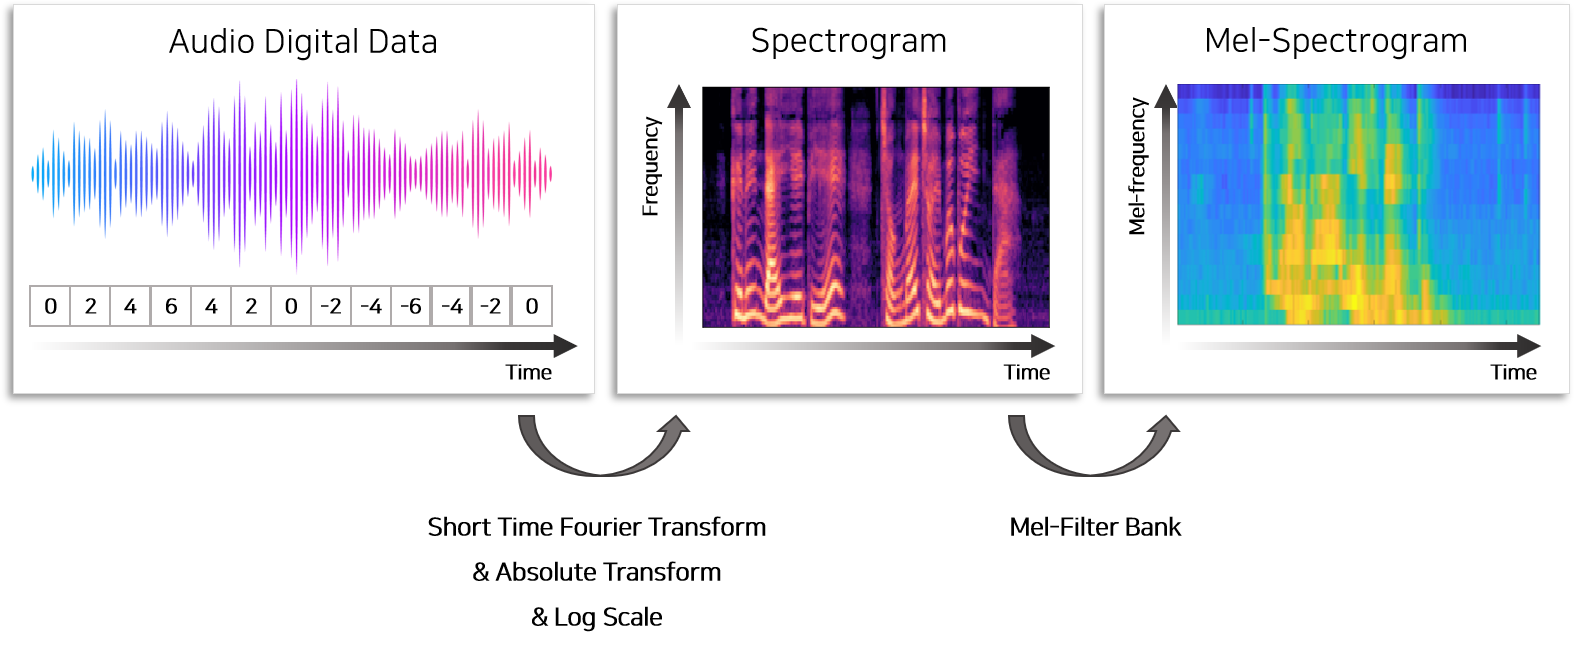

><h5>오디오 데이터 전처리 예시</h5>

<h2>2, CBHG 모듈</h2>

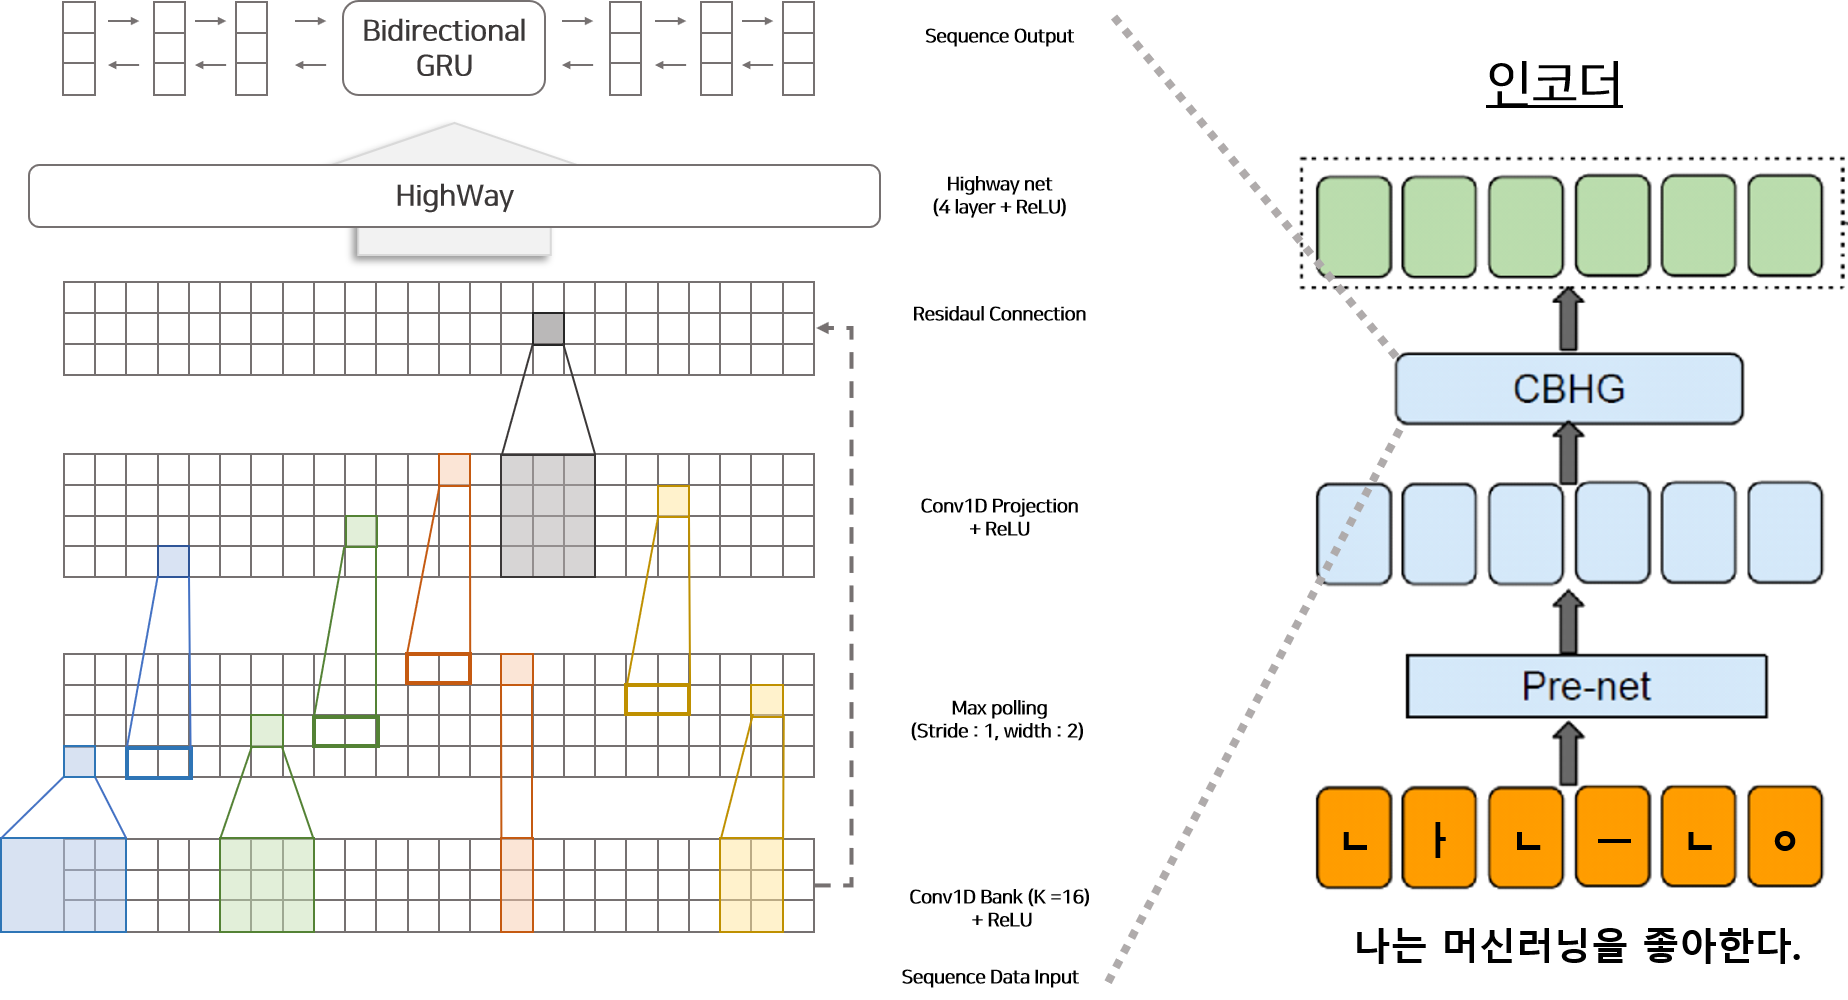

><h5>Encoder에 적용된 CBHG 모듈 예시</h5>

<h3>CBHG모듈은 <u>Encoder와 Decoder에 공통적으로 존재</u>하는 모듈로써 Sequence데이터를 처리하는데 특화되어 있다. CBHG모듈은 1D <b>C</b>onvlution <b>B</b>ank, <b>H</b>ighway 네트워크, Bidirectional <b>GRU</b>로 구성되어 있다. 모듈은 Sequence Vector를 Input으로 사용하며 Sequence Vector가 Output으로 추출된다.  모듈의 상세 프로세스는 아래와 같다.</h3>

<center>
<h4>
1, Sequence 데이터를 1부터 K개의 필터를 갖고 있는 <b>1D Convolution Back</b>에 통과시켜 Feature Vector를 생성한다.
<br>
2, Feature Vector를 <b>Max polling Layer</b>에 통과시켜 Squence에 따라 변하지 않는 부분(local invariance)을 추출한다.
<br>
3, 고정된 폭을 갖는 몇개의 <b>1D Convolution Back</b>을 통과시켜 Sequence데이터의 Vector 사이즈와 일치하는 벡터를 생성한다.
<br>
4, 3)에서 생성된 벡터와 1)의 Sequance Input Vector를 더하여 <b>Residual Connection</b>을 구성한다.
<br>
5, 4)에서 생성된 Vector를 <b>Highway Network</b>에 통과시켜 high-level features를 생성한다.
<br>
6, high-level feature를 <b>GRU</b>의 입력으로 사용한다.
</h4>
</center>

<h3>
1D Convolution Bank는 총 K개의 필터를 갖고 있습니다. 필터는 각각 K의 길이(1 ~  K)를 갖고 있다. 즉, 각 필터는 K개의 Sequance를 보고 연산을 통해 특정 <b>길이(K)를 고려하여 정보를 추출</b>하는 역할을 한다. CBHG 모듈 안에 있는 4)Residual Connection은 모델을 깊게 쌓을 수 있게 하며 학습할 때 <u>빠르게 수렴할 수 있도록</u> 돕는 역할을 한다. 모든 1D Convolution Network는 Batch Normalization을 포함하고 있어 <u>정규화 작용</u>을 합니다.
</h3>

<h1>Highway Network</h1>
<center><h2>$$Highway(x) = T(x) * H(x) + (1 - T(x)) * x$$ </h2></center>
<br>
$$ T(x) = \sigma(FC(x)) : FC Layer + Sigmoid $$
$$ H(x) = FC(x) : FC Layer $$
<br>
<br>
<h3>
Highway Network는 <b>Gate구조</b>를 추가한 <u>Residual Connection</u>이다. 일반적인 Residual Connection은 Input x와 함수 H(x)가 있을 때 결과 y와의 관계를 y = x + H(x)로 정의한다.
HighWay Network는 x와 H(x)를 <u>어느정도 비율로 섞을지</u>를 학습하여 결정할 수 있도록 0~1의 값을 갖는 T(x)를 만들어 x와 H(x)에 곱해준다.
</h3>

<h1>3, Encoder</h1>

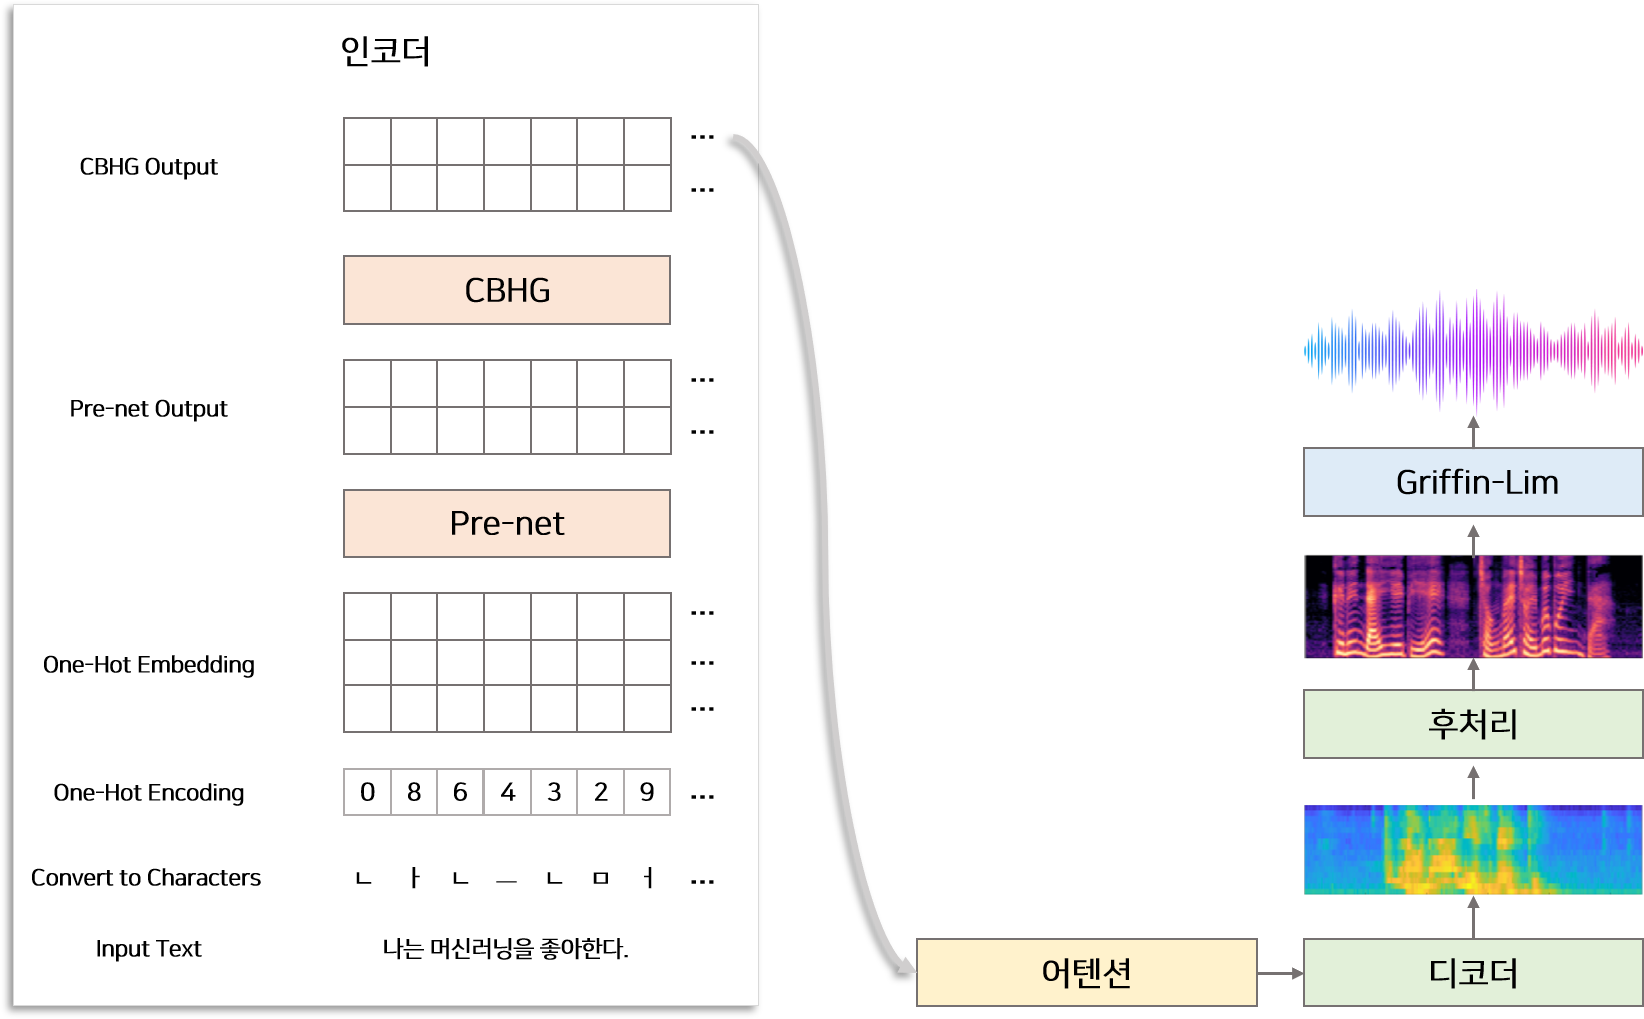

><h5>Encoder 상세구조</h5>

<h3>Encoder는 문장으로부터 <b>고정된 길이의 특징(Vector)를 추출</b>하는 것이 목적이다. 따라서 앞서 설명한 것 처럼 캐릭터 단위로 나뉜 Character One-Hot Vector가 Encoder의 Input으로 들어와 어텐션 모듈에서 사용될 Sequebce Vector로 변환되는 과정은 아래와 같다.</h3>
<br>

><h4>
1, Embading Matrix를 이용하여 One-Hot Vector로 표현된 Character Input을 Embading Vector로 변환한다.
<br>
2, Embading Vector를(FC layer + Lelu + Dropout)으로 구성된 Pre-net 모듈에 통과시킨다.
<br>
3, Pre-net을 통과시켜 생성된 Vector를 CBHG에 넣으면 어텐션 모듈에서 활용될 Sequence Vector가 생성된다.
</h4>
<br>
</center>
<h3>Pre-Net에는 2층의 Fully Connected Layer(FC Layer)이다. 이모듈은 <u>과적합을 막기위한 목적</u>으로 <b>Dropout이 적용</b>되어 있다.</h3>

<h1>4, Decoder</h1>


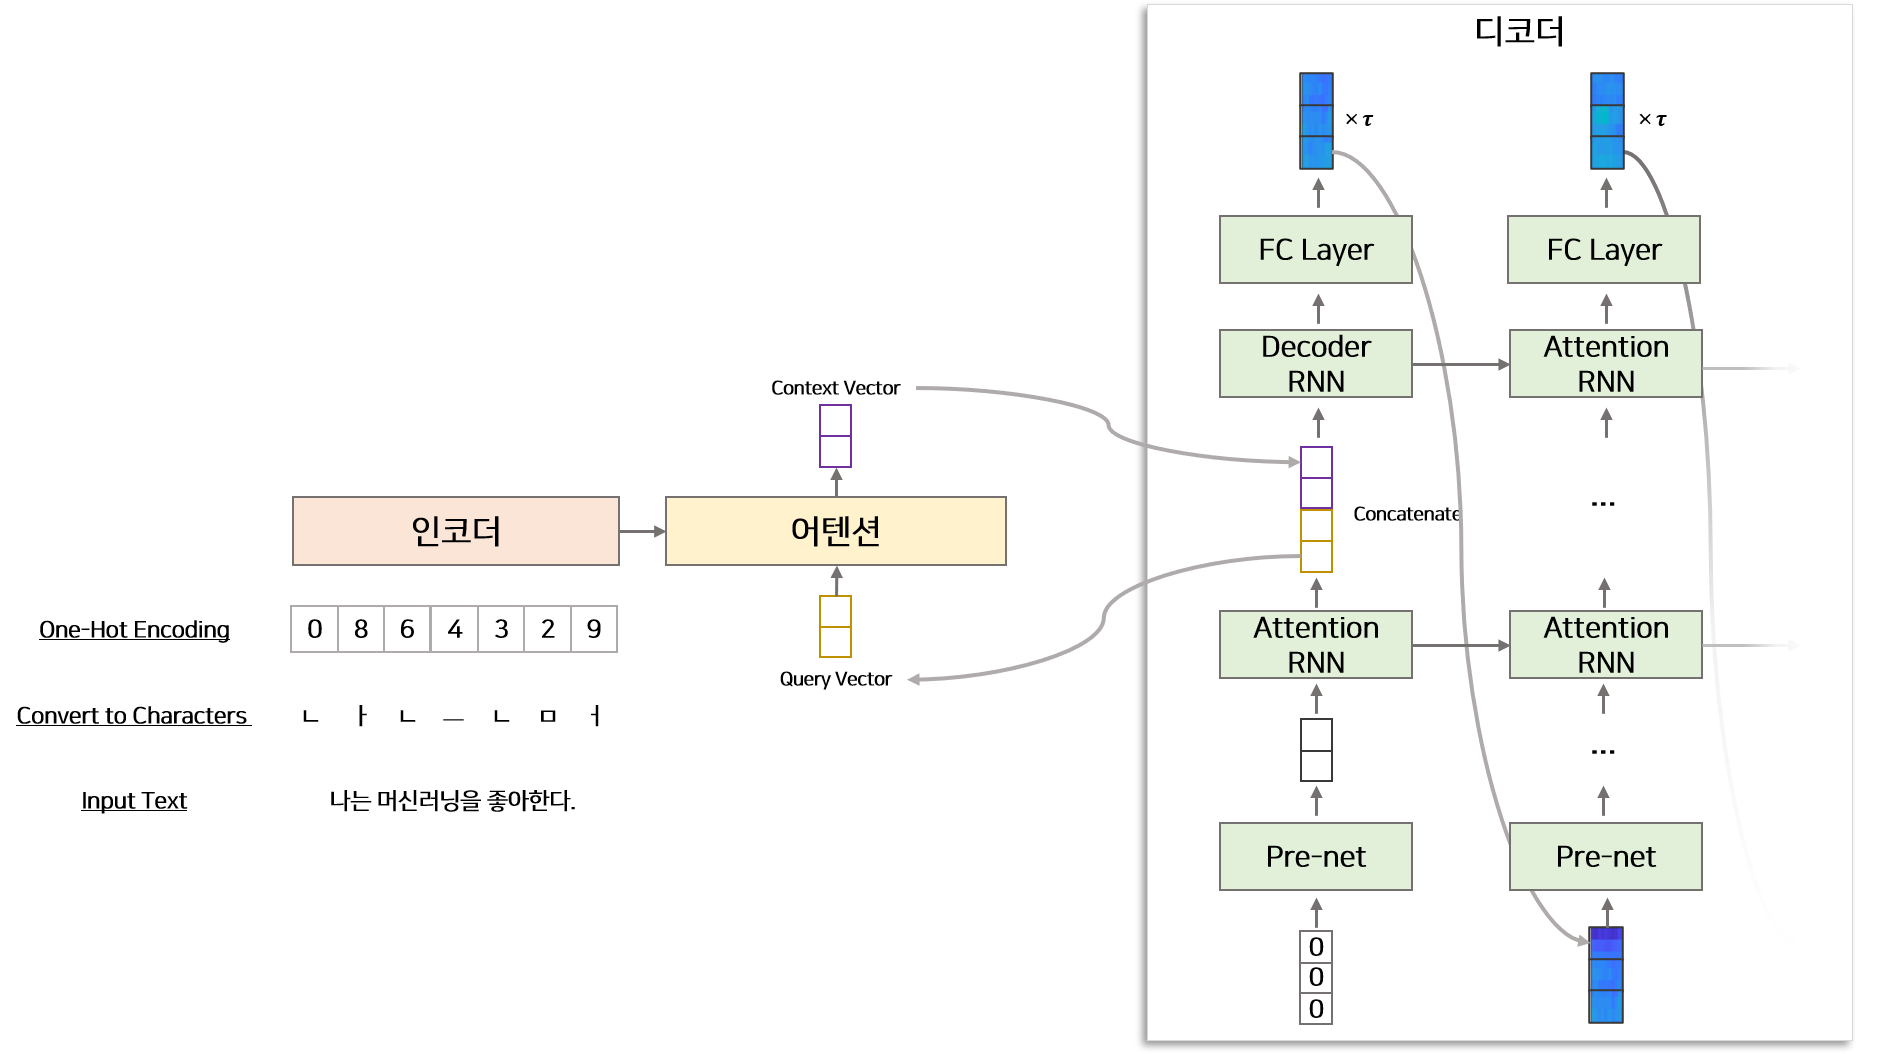

><h5>Decoder 상세구조<h5>



<h3>
Decoder는 Encoder에서 생성된 Sequence Vector와 t - 1<b>시점까지</b> 생성된 Decode의 멜 스펙토그램을 Input으로 받아 t <b>시점의 멜 스펙토그램을 생성</b>합니다. <u>어텐션 기반 모델</u>이므로 Decoder Attention-RNN에서 생성된 hidden Vector(dt)를 query로 이용하여 Encoder의 정보를 추출하고 가중합하여 Context Vector(ct)를 계산하고 Decoder-RNN 모듈에 사용한다.
</h3>


>1, Decoder의 Input은 t - 1 시점까지 Decoder에서 생성된 <b>멜 스펙토그램</b>입니다. 처음 시점에는 생성된 멜 스펙토그램이 없으므로 모든 값이 0인 멜 스펙토그램을 Input으로 사용한다.<br>

>2, 멜 스펙토그램을 Pre-Net 모듈에 통과시켜 Vector를 생성 한 후 Attention-RNN의 Input으로 사용한다<br>

>3, Attention-RNN으로 부터 추출된 Sequence hidden Vector(d1, d2, ..., dt)를 어텐션 모듈에 넣어 Encoder의 Vector의 각 시점과 관련된 Vector의 가중합인 <b>Context Vector(c1, c2, ... ct)를 추출</b>한다.<br>

>4,  Attention-RNN hidden Vector(d1, d2, ..., dt)와 Context Vector(c1, c2, ..., ct)를 Concatenate 하여 Decoder-RNN의 Input으로 사용한다.<br>

>5, Decoder-RNN에서 추출된 결과가 Decoder의 Output인 t시점의 델 스펙토그램이다.


<h3>
Encoder와 마찬가지로 Decoder의 Pre-Net도 <u>과적합을 막기 위한 목적</u>으로 <b>Dropout이 적용</b>되어 있는 Fully Connected Layer입니다. Decoder의 결과물은 멜 스펙토그램이다. 일반적으로 오디오로부터 추출한 멜 스펙토그램은 시간에 따라 천천히 변하는 연속한 프레임으로 구성되어 있습니다. 따라서 <b>겹치는 정보가 많으므로</b>(연속시점의 멜 스펙토그램은 반복되는 프레임으로 구성된 경우가 많음) Decoder에서 <b>한 시점에서 여러개(τ)의 멜 스펙토그램을 생성</b>하여 학습 및 수렴 속도를 상승시킨다. 즉 총 p길이의 멜 스펙토그램이 존재하면 Decoder에서 예측하는 총 시점은 t = p / τ가 된다. 그리고 <u>매 시점별 Decoder에서 생성된 멜 스펙토그램</u>을 <b>τ개 복사</b>하여 후처리 모듈의 Input으로 사용한다.
</h3>

<h1>5, Attention</h1>

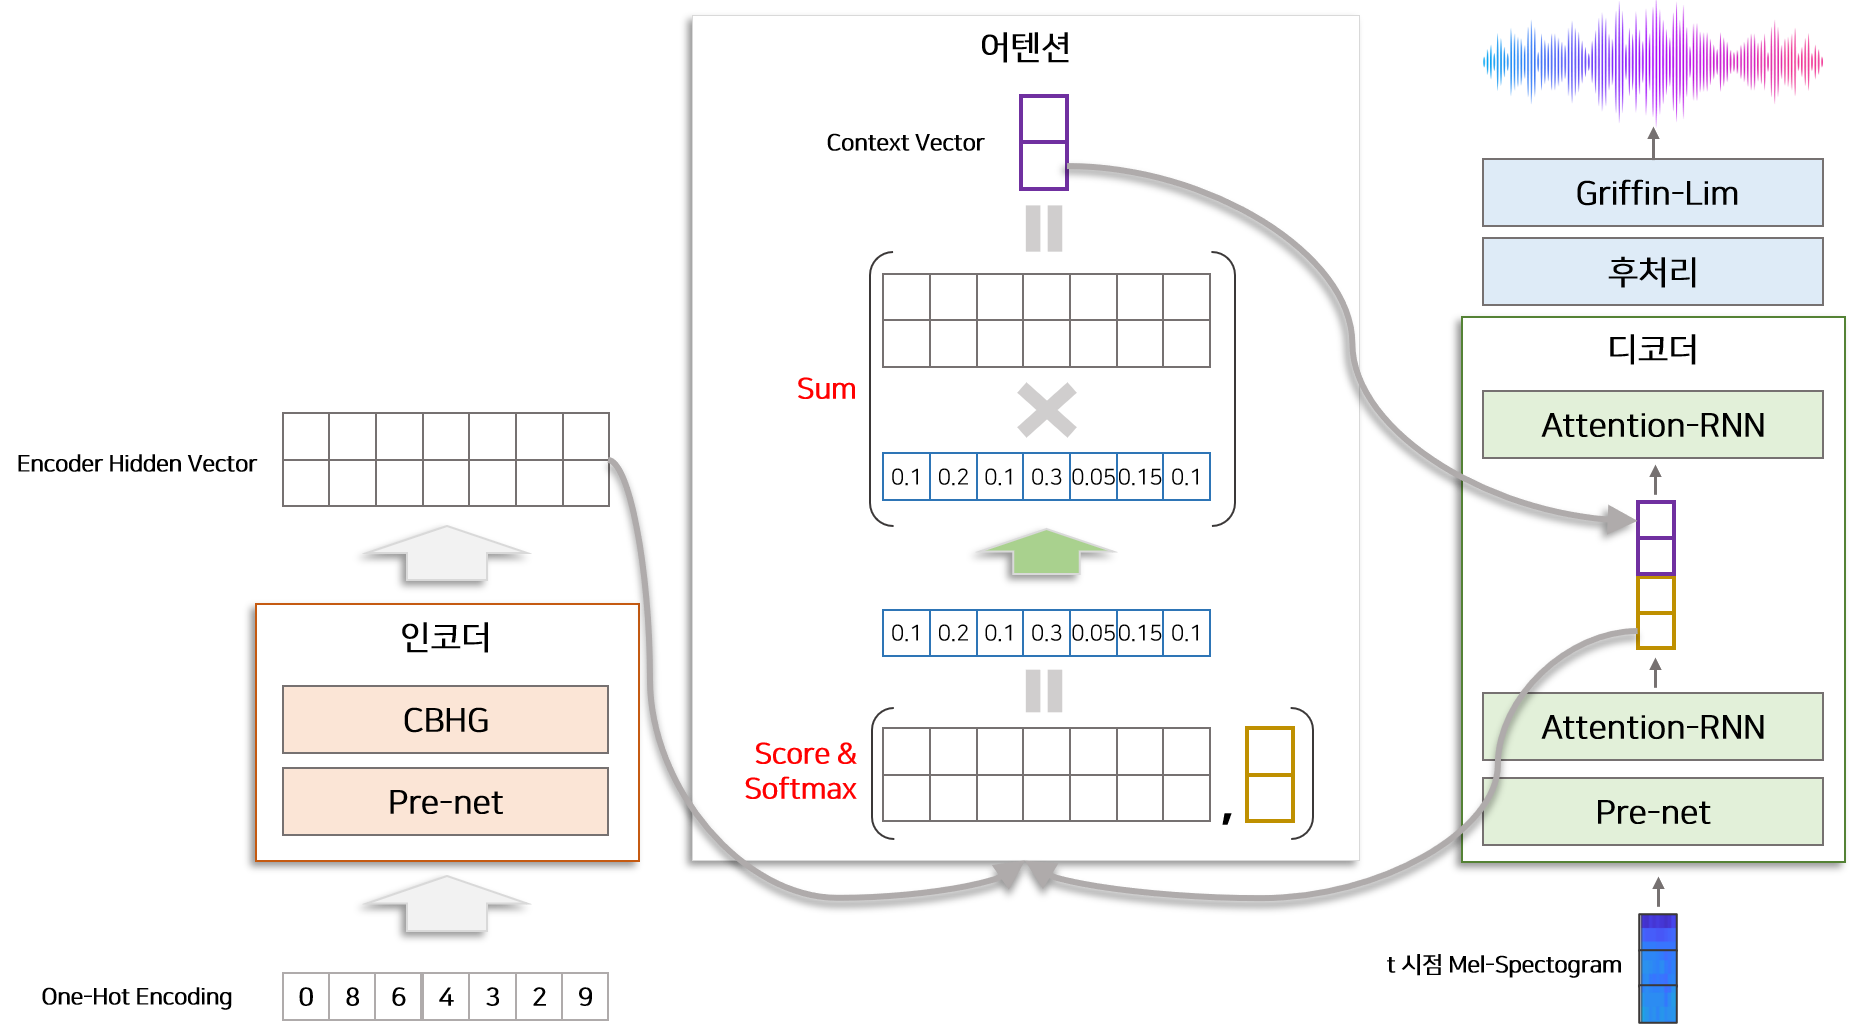

><h5>Attention 상세구조<h5>


<h3>
Seq2Seq 구조의 특성상 Encoder와 Decoder 사이에 <u>Bottle Neck이 존재</u>하여 모델 정확도가 하락하거나 Gradient Vanishing문제가 발생하므로 이를 해결하기 위하여 <b>어텐션 구조</b>가 제안되었다. 어텐션에는 다양한 형태가 존재하지만 타코트론에서 적용한 방법은<a href = "https://arxiv.org/abs/1409.0473">Bahdanau Attention</a>이다.<br>
h1, h2, ..., hn는 Encoder에서 생성된 n개의 Hidden Vector이고, Decoder의 모듈 Attention-RNN에서 t시점에 생성된 Hidden Vector를 dt라고 할때 Bahdanau Attention 통해 구한 Contest Vector ct는 아래와 같다.
</h3>

$$ C_t = \sum_{j=1}^n a_{tj}h_j$$<br>

$$ a_{tj} = {exp(score(d_t, h_j)) \over {\sum_{i=1}^n exp(score(d_t, h_j)) } } $$<br>

$$ score(d_t, h_j) = v^Ttanh(w_dd_t + w_hh_j)$$

<h3>
위 식은 <a href = "https://medium.com/analytics-vidhya/neural-machine-translation-using-bahdanau-attention-mechanism-d496c9be30c3">Medium BLOG</a>글을 참고하여 재구성하였다. 위의 식이 전체적으로 의미하는 것은 dt와 hn가 <u>얼마나 유사한지를 계산하고</u> 그 <b>비율대로 hn을 곱하여 Context Vector ct를 구성</b>하는 것이다. 좀 더 자세하게 설명하면 Score Function에서 wa, wh는 각 Encoder, Decoder에서 생성된 Hidden Vector를 낮은 차원으로 사영(Projection)하는 Fully Connected Layer이다. 이 Layer를 통해 동일한 차원으로 사영된 벡터를 서로 합하여 tanh 비선형 함수를 씌운뒤 v^T Vector와 Element-Wise곱하여 <u>하나의 숫자</u>로 변형한다. 이 숫자가 의미하는 것은 dt와 hn가 주어졌을 때 계산된 <b>유사도 점수</b>입니다. 이 <u>유사도 점수를 기반</u>으로 각 Encoder의 Hidden Vector를 <b>가중합</b> 한 Vector가 Context Vector ct이다
</h3>

<h1>6, 후처리(Post Processing) & Griffin-Lim 알고리즘</h1>

<h3>
후처리 모듈은 <u>Decoder에서 생성된 멜 스펙토그램</u>을 이용하여 <b>Linear 스펙토그램을 생성</b>하기 위한 과정이다.
Seq2Seq 모델의 특성상 Decoder는 시점별로 한개씩 멜 스펙토그램을 생성하지만 후처리에서는 <b>Decoder에서 멜 스펙토그램을 모두 생성한 후</b> 이를 이용하여 Linear 스펙토그램을 생성한다. 즉 후처리는 <b>멜 스펙토그램의 전체 모습을 보고</b> Linear 스펙토그램을 생성하므로 후처리 모듈없이 <u>Decoder에서 바로 Linear스펙토그램을 생성한 타코트론 모델보다 좋은 품질</u>의 음성을 생성한다. 후처리 모듈은 CBHG모듈로 구성되어 있다.<br><br>
Griffin-Lim 알고리즘은 Linear <u>스펙토그램을 음성 신호로 합성</u>하는데 사용하는 알고리즘이다. 이 알고리즘은 특정 모델을 가정하지 않고 음성을 합성할 수 잇으며 단순 반복작업을 통하여 음성신호를 생성하므로 <u>계산량에 있어서 일반적인 보코더보다 유리한 장점</u>을 갖고 있다. 자센한 사항은 <a href = "https://paperswithcode.com/method/griffin-lim-algorithm">Griffin-Lim Algorithm</a>참고하라.
</h3>

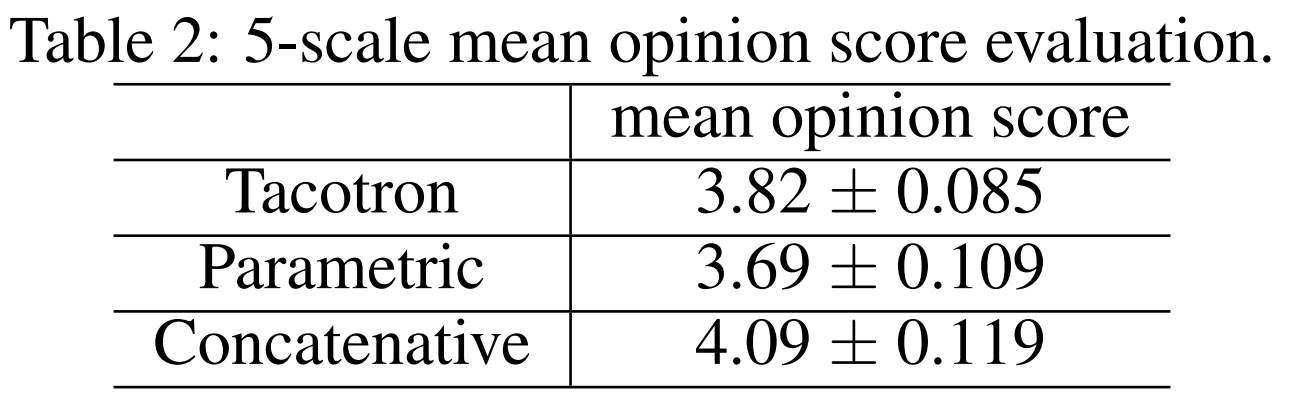

<h3>
TTS(Text to Speech) Task에서 모델의 성능을 평가하기 위하여 피실험자에게 실험모델로부터 생성된 음성을 들려주고 1~5점의 품질 점수를 선택하도록 하는 실험(MOS TEST)을 진행한다. 비교모델로 LSTM기반 Parametric모델과 Concatenative 모델보다 낮은 평가점수를 획득하였지만 타코트론은 텍스트를 분석하거나 음향 모델링과 같은 <u>전문가의 손길 없이 구현이 가능</u>하므로 고무적인 성과로 볼 수 있다.
</h3>